# Data exploration and preprocessing

In [195]:
import itertools
import os.path
import xml.etree.ElementTree as ET

import biographs as bg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from Bio.PDB import *
from biopandas.pdb import PandasPdb
from proteingraph import read_pdb
from torch import nn
from torch.nn import Linear
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, GraphConv, global_mean_pool, GATv2Conv
from torch_geometric.utils.convert import from_networkx

## Read datasets

In [62]:
challanges = ["pz0" + str(i) for i in range(1, 10)]
challanges.append("pz10")
challanges

['pz01',
 'pz02',
 'pz03',
 'pz04',
 'pz05',
 'pz06',
 'pz07',
 'pz08',
 'pz09',
 'pz10']

### Motives

In [63]:
motives_dfs = []

for challange in challanges:
    motive_df = pd.read_csv(
        f"data/raw/RNA-Puzzles/{challange}/filter-results.txt",
        delimiter="\t",
        header=None,
        names=[
            "filename",
            "number_of_schemes",
            "number_of_rests",
            "nucleotide ranges",
            "sequence",
        ],
    )
    motive_df["challange_num"] = challange
    motives_dfs.append(motive_df)

motives = pd.concat(motives_dfs, axis=0, ignore_index=True)

In [64]:
motives

,filename,number_of_schemes,number_of_rests,nucleotide ranges,sequence,challange_num
0,1_solution_0_rpr_A_3_G,2,15,"A1-A7, B11-B18","CCGCCGC, AUGCCUGU",pz01
1,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
2,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
3,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
4,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
...,...,...,...,...,...,...
1109,10_0_solution_4LCK_rpr_B_60_C,2,22,"B13-B20, B51-B64","CAGUGGUA, GGUUCGAAUCCCGU",pz10
1110,10_0_solution_4LCK_rpr_B_61_C,2,22,"B14-B19, B50-B65","AGUGGU, GGGUUCGAAUCCCGUC",pz10
1111,10_0_solution_4LCK_rpr_B_62_C,2,17,"B49-B55, B57-B66","CGGGUUC, AAUCCCGUCU",pz10
1112,10_0_solution_4LCK_rpr_B_63_G,2,15,"B48-B54, B59-B66","GCGGGUU, UCCCGUCU",pz10


#### Drop motives with number_of_schemes < 3

In [65]:
motives = motives[motives["number_of_schemes"] >= 3]
motives

,filename,number_of_schemes,number_of_rests,nucleotide ranges,sequence,challange_num
1,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
2,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
3,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
4,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
5,1_solution_0_rpr_A_8_G,3,24,"A4-A12, B5-B12, B15-B21","CCGCGCCAU, CGCGCCAU, CUGUGGC",pz01
...,...,...,...,...,...,...
1104,10_0_solution_4LCK_rpr_B_55_C,3,32,"A48-A63, B16-B21, B50-B59","AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU",pz10
1105,10_0_solution_4LCK_rpr_B_56_G,3,38,"A48-A64, B15-B22, B49-B61","AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC",pz10
1106,10_0_solution_4LCK_rpr_B_57_A,4,42,"A49-A54, A58-A64, B14-B22, B44-B63","GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG",pz10
1107,10_0_solution_4LCK_rpr_B_58_A,4,43,"A59-A63, B6-B11, B13-B23, B43-B63","AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG",pz10


### Target

In [66]:
def parse_scores_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    structure_list = []
    for structure in root.iter("structure"):
        filename = structure.find("description").find("filename").text
        score = structure.find("score").text
        structure_list.append([filename, score])

    structure_df = pd.DataFrame(structure_list, columns=["filename", "score"])
    return structure_df

In [67]:
for filename in motives["filename"]:
    xml_path = filename + "-rmsd.xml"

In [68]:
solutions_with_no_xml_file = []
scores = []

for index, row in motives.iterrows():
    xml_path = f"data/raw/RNA-Puzzles/{row['challange_num']}/{row['filename']}-rmsd.xml"

    if os.path.isfile(xml_path):
        xml_df = parse_scores_xml(xml_path)
        xml_df["solution"] = row["filename"]
        xml_df[
            "pdb_path"
        ] = f"data/raw/RNA-Puzzles/{row['challange_num']}/{row['filename']}/" + xml_df[
            "filename"
        ].astype(
            str
        )

        xml_df[
            "tor_path"
        ] = f"data/raw/RNA-Puzzles/{row['challange_num']}/{row['filename']}/" + xml_df[
            "filename"
        ].apply(
            lambda x: str(x[:-3]) + "tor"
        )

        scores.append(xml_df)
    else:
        solutions_with_no_xml_file.append(index)

scores_df = pd.concat(scores)
scores_df

,filename,score,solution,pdb_path,tor_path
0,1_bujnicki_1_rpr.pdb,4.769,1_solution_0_rpr_A_4_C,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...
1,1_bujnicki_2_rpr.pdb,4.594,1_solution_0_rpr_A_4_C,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...
2,1_bujnicki_3_rpr.pdb,3.921,1_solution_0_rpr_A_4_C,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...
3,1_bujnicki_4_rpr.pdb,4.522,1_solution_0_rpr_A_4_C,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...
4,1_bujnicki_5_rpr.pdb,4.616,1_solution_0_rpr_A_4_C,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...,data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_4...
...,...,...,...,...,...
21,10_DING_5_rpr.pdb,4.516,10_0_solution_4LCK_rpr_B_59_U,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...
22,10_DING_6_rpr.pdb,3.939,10_0_solution_4LCK_rpr_B_59_U,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...
23,10_DING_7_rpr.pdb,4.639,10_0_solution_4LCK_rpr_B_59_U,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...
24,10_DING_8_rpr.pdb,5.66,10_0_solution_4LCK_rpr_B_59_U,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...,data/raw/RNA-Puzzles/pz10/10_0_solution_4LCK_r...


#### Drop motives with no xml

In [69]:
motives = motives.drop(solutions_with_no_xml_file)
motives

,filename,number_of_schemes,number_of_rests,nucleotide ranges,sequence,challange_num
1,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
2,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
3,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
4,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
5,1_solution_0_rpr_A_8_G,3,24,"A4-A12, B5-B12, B15-B21","CCGCGCCAU, CGCGCCAU, CUGUGGC",pz01
...,...,...,...,...,...,...
1104,10_0_solution_4LCK_rpr_B_55_C,3,32,"A48-A63, B16-B21, B50-B59","AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU",pz10
1105,10_0_solution_4LCK_rpr_B_56_G,3,38,"A48-A64, B15-B22, B49-B61","AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC",pz10
1106,10_0_solution_4LCK_rpr_B_57_A,4,42,"A49-A54, A58-A64, B14-B22, B44-B63","GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG",pz10
1107,10_0_solution_4LCK_rpr_B_58_A,4,43,"A59-A63, B6-B11, B13-B23, B43-B63","AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG",pz10


In [70]:
motives.describe()

,number_of_schemes,number_of_rests
count,666.000000,666.000000
mean,3.638138,31.304805
std,0.852939,7.616082
min,3.000000,18.000000
25%,3.000000,25.000000
50%,3.000000,30.500000
75%,4.000000,36.000000
max,8.000000,61.000000


## Graphs

In [128]:
def parse_pdb_file(pdb_path, atom="C5"):
    pdb_df = PandasPdb().read_pdb(pdb_path).df["ATOM"]
    
    pdb_df = pdb_df[pdb_df["atom_name"] == atom]

    pdb_df["node"] = (
        pdb_df["chain_id"]
        + pdb_df["residue_number"].astype(str)
        + pdb_df["residue_name"]
    )
    pdb_df = pdb_df[
        [
            "node",
            "x_coord",
            "y_coord",
            "z_coord",
        ]
    ].set_index("node")
    return pdb_df

In [129]:
def parse_tor_file(tor_file_path):
    tor_df = pd.read_csv(tor_file_path, delimiter="\t", na_values="-")
    tor_df = tor_df[
        [
            "Chain",
            "ResNum",
            "Name",
            "alpha",
            "beta",
            "gamma",
            "delta",
            "epsilon",
            "zeta",
            "chi",
        ]
    ].fillna(0)
    tor_df["node_name"] = (
        tor_df["Chain"] + tor_df["ResNum"].astype(str) + tor_df["Name"]
    )

    tor_df["angles"] = tor_df[
        ["alpha", "beta", "gamma", "delta", "epsilon", "zeta", "chi"]
    ].values.tolist()

    # AUGC
    tor_df["ChainOH"] = (tor_df["Chain"] == "A").astype(int)
    tor_df["NameA"] = (tor_df["Name"] == "A").astype(int)
    tor_df["NameU"] = (tor_df["Name"] == "U").astype(int)
    tor_df["NameG"] = (tor_df["Name"] == "G").astype(int)
    tor_df["NameC"] = (tor_df["Name"] == "C").astype(int)

    # return tor_df
    return [
        (
            row["node_name"],
            {
                "x": row["angles"]
                + [row["ChainOH"]]
                + [row["NameA"]]
                + [row["NameU"]]
                + [row["NameG"]]
                + [row["NameC"]]
            },
        )
        for index, row in tor_df.iterrows()
    ]

In [131]:
def pdb_to_networkx(pdb_file, tor_file, cutoff=16):
    pdb_df = parse_pdb_file(pdb_file)
    nodes_list = parse_tor_file(tor_file)

    pdb_graph = nx.Graph()
    pdb_graph.add_nodes_from(nodes_list)

    edges_list = []
    for node1, node2 in itertools.combinations(pdb_df.index, 2):
        # "distance" has to be changed according to pyg way
        euclidean_dist = np.linalg.norm(pdb_df.loc[node1] - pdb_df.loc[node2])
        if euclidean_dist <= cutoff:
            edges_list.append((node1, node2, {"edge_attr": euclidean_dist}))
    pdb_graph.add_edges_from(edges_list)
    return pdb_graph

### Example

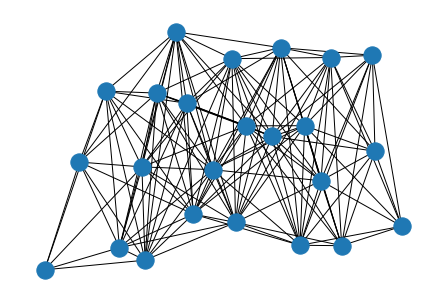

In [136]:
network_example = pdb_to_networkx(
    "data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_10_C/1_bujnicki_1_rpr.pdb",
    "data/raw/RNA-Puzzles/pz01/1_solution_0_rpr_A_10_C/1_bujnicki_1_rpr.tor",
    cutoff=16,
)
nx.draw(network_example)

In [137]:
len(network_example.nodes.data())

24

In [138]:
len(network_example.edges.data())

149

In [139]:
pyg_graph = from_networkx(network_example)
pyg_graph

Data(x=[24, 12], edge_index=[2, 298], edge_attr=[298])

In [140]:
print(pyg_graph.x)

tensor([[   0.0000,  169.8750,   66.5510,   81.8650, -157.0760,  -68.3060,
         -165.3180,    1.0000,    0.0000,    0.0000,    1.0000,    0.0000],
        [ -77.5540,  168.6110,   76.6300,   85.7530, -151.7670,  -62.1320,
         -161.7940,    1.0000,    0.0000,    0.0000,    0.0000,    1.0000],
        [ -75.8580, -179.9440,   76.8070,   79.8310, -153.7470,  -75.8980,
         -168.7670,    1.0000,    0.0000,    0.0000,    1.0000,    0.0000],
        [ -77.7460,  170.4360,   70.3980,   83.3820, -157.1560,  -62.3450,
         -156.9230,    1.0000,    0.0000,    0.0000,    0.0000,    1.0000],
        [ -79.4450,  169.2910,   70.6340,   80.7770, -157.3780,  -73.8120,
         -161.4290,    1.0000,    0.0000,    0.0000,    0.0000,    1.0000],
        [ -77.8660,  165.4800,   78.6220,   87.4720, -150.3620,  -78.9660,
         -162.2840,    1.0000,    1.0000,    0.0000,    0.0000,    0.0000],
        [ -79.1270,  165.5860,   67.7550,   86.0390, -156.6130,  -66.6070,
         -149.2940,

## Dataset loader

In [141]:
pdb_files = scores_df["pdb_path"].to_list()

In [142]:
tor_files = scores_df["tor_path"].to_list()

In [143]:
labels = scores_df["score"].to_list()

In [144]:
assert len(pdb_files) == len(tor_files) and len(tor_files) == len(labels)

In [145]:
class RNAPuzzlesDataset(InMemoryDataset):
    def __init__(
        self,
        root,
        pdb_filenames,
        tor_filenames,
        labels,
        transform=None,
        pre_transform=None,
        pre_filter=None,
    ):
        self.pdb_filenames = pdb_filenames
        self.tor_filenames = tor_filenames
        self.labels = labels
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # DONE
        return self.pdb_filenames + self.tor_filenames

    @property
    def processed_file_names(self):
        return "data.pt"

    def download(self):
        pass

    def process(self):
        data_list = []

        for pdb_file, tor_file, label in zip(
            self.pdb_filenames, self.tor_filenames, self.labels
        ):
            try:
                networkx_graph = pdb_to_networkx(pdb_file, tor_file, cutoff=16)
                pyg_graph = from_networkx(networkx_graph)
                pyg_graph.y = float(label)

                data_list.append(pyg_graph)
            except:
                print("Wrong file:", pdb_file, tor_file)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [147]:
dataset = RNAPuzzlesDataset(
    root="data", pdb_filenames=pdb_files, tor_filenames=tor_files, labels=labels
)

### Train/test split and data loaders

In [148]:
len(dataset)

20453

In [149]:
dataset.shuffle()

RNAPuzzlesDataset(20453)

In [150]:
train_dataset = dataset[:15000]
test_dataset = dataset[15000:]

In [151]:
batch_size = 64
num_examples = 15000

In [152]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [153]:
len(train_dataset)

15000

In [154]:
len(test_dataset)

5453

In [155]:
train_dataset[0].edge_attr

tensor([ 3.9917,  7.9729, 11.1333, 14.4394, 12.7221, 11.4864, 10.0820,  8.3248,
         7.0205,  3.9917,  4.4002,  7.5049, 11.1724, 13.8888, 11.2157,  9.8450,
         9.0251,  7.0731,  6.8923,  7.9729,  4.4002,  3.6566,  7.5573, 11.1618,
        14.0621,  9.5469,  7.4994,  7.1428,  5.6124,  7.5127, 11.1333,  7.5049,
         3.6566,  4.1343,  8.4112, 11.0863, 14.7543,  8.3715,  7.0694,  8.2089,
         8.2700, 10.9646, 14.4394, 11.1724,  7.5573,  4.1343,  4.9564,  7.5614,
        13.3641, 14.9339, 13.6350,  7.0591,  6.8413,  9.3239, 11.0391, 14.4263,
        13.8888, 11.1618,  8.4112,  4.9564,  3.6947,  9.9021, 14.7842, 13.5424,
        12.0236,  4.9012,  6.9871, 10.4275, 13.7115, 14.0621, 11.0863,  7.5614,
         3.6947,  6.5077, 15.9028, 14.0438, 11.5514, 10.8410, 10.0412,  7.7531,
        10.5424, 14.0114, 13.3641,  9.9021,  6.5077, 14.4463, 11.8560,  9.1320,
         7.3801,  6.8995,  6.9941, 12.4700, 15.9947,  5.2684,  8.6204, 11.7706,
        15.7702, 14.4463,  5.2684,  3.87

## Network

In [223]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        # self.conv4 = GraphConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, 1)

    def forward(self, data):
        x, pos, edge_index, edge_weight = data.x, data.pos, data.edge_index, 1/data.edge_attr.float()
        
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        # F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        # F.dropout(x, training=self.training)

        x = self.conv3(x, edge_index, edge_weight)
        # x = x.relu()
        # x = self.conv4(x, edge_index, edge_weight)

        x = global_mean_pool(x, data.batch)

        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin(x)

        return x.squeeze()

In [224]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.head = 8

        self.conv1 = GATv2Conv(dataset.num_features, self.hid, heads=self.head, edge_dim=1)
        self.conv2 = GATv2Conv(self.hid * self.head, self.hid, heads=self.head, edge_dim=1)

        self.lin = nn.Linear(self.hid * self.head, 1)

    def forward(self, data):
        x, pos, edge_index, edge_attr = data.x, data.pos, data.edge_index, 1/data.edge_attr.float()

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)

        x = global_mean_pool(x, data.batch)
        
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x.squeeze()

In [225]:
model = GCN(32)
# model = GAT()

print(model)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 1e-4
criterion = nn.MSELoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01) ** (1.0 / epochs))

GCN(
  (conv1): GraphConv(12, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


In [226]:
def train():
    model.train()
    for i, data in enumerate(train_loader):
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()


@torch.no_grad()
def test(loader):
    model.eval()
    valid_loss = 0.0
    for i, data in enumerate(loader):
        out = model(data)
        loss = criterion(out, data.y)
        valid_loss += loss.item()
    return (valid_loss / len(loader)) ** 0.5


for epoch in range(1, epochs):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    print(
        f"Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}"
    )

Epoch: 001, Train loss: 6.2327, Test loss: 4.2771
Epoch: 002, Train loss: 6.0796, Test loss: 5.5984
Epoch: 003, Train loss: 6.5864, Test loss: 4.1268
Epoch: 004, Train loss: 6.0113, Test loss: 4.3243
Epoch: 005, Train loss: 5.7370, Test loss: 5.3528
Epoch: 006, Train loss: 5.5917, Test loss: 4.6087
Epoch: 007, Train loss: 5.6641, Test loss: 5.0460
Epoch: 008, Train loss: 5.4912, Test loss: 5.1708
Epoch: 009, Train loss: 5.3757, Test loss: 5.2663
Epoch: 010, Train loss: 5.5204, Test loss: 4.7421
Epoch: 011, Train loss: 5.2881, Test loss: 5.4478
Epoch: 012, Train loss: 5.2845, Test loss: 5.0481
Epoch: 013, Train loss: 5.2865, Test loss: 4.1744
Epoch: 014, Train loss: 5.1257, Test loss: 4.4234
Epoch: 015, Train loss: 5.1080, Test loss: 4.9738
Epoch: 016, Train loss: 4.9971, Test loss: 4.7177
Epoch: 017, Train loss: 5.0637, Test loss: 4.9075
Epoch: 018, Train loss: 5.3029, Test loss: 4.2937
Epoch: 019, Train loss: 4.9574, Test loss: 4.4664


KeyboardInterrupt: 